# Non-stationarity and unit root processes

In [1]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

from statsmodels.tsa.deterministic import DeterministicProcess
import pandas as pd
import numpy as np



from numpy.random import default_rng
from statsmodels.tsa.arima_process import arma_acovf, ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
gen = default_rng(1)
import seaborn as sns
sns.set_theme()
sns.set_context("talk")


In [2]:
df = pd.read_excel('nama_10_gdp__custom_2373104_page_spreadsheet.xlsx',
                   sheet_name='Sheet 1',
                  skiprows=range(9), usecols=[0,1], names=['year', 'GDP'], index_col=0, parse_dates=True,
                  ).loc['1995':'2021']
df = df.astype('float')
data = np.log(df['GDP'])
title='Real GDP, Euro Area'
ylabel='natural log of millions of euro'


## Why need stationarity?

* stationarity is a form of constancy of the properties of the process (mean, variance, autocovariances)
* needed in order to be able to learn something about those properties

Many macroeconomic time series are non-stationary

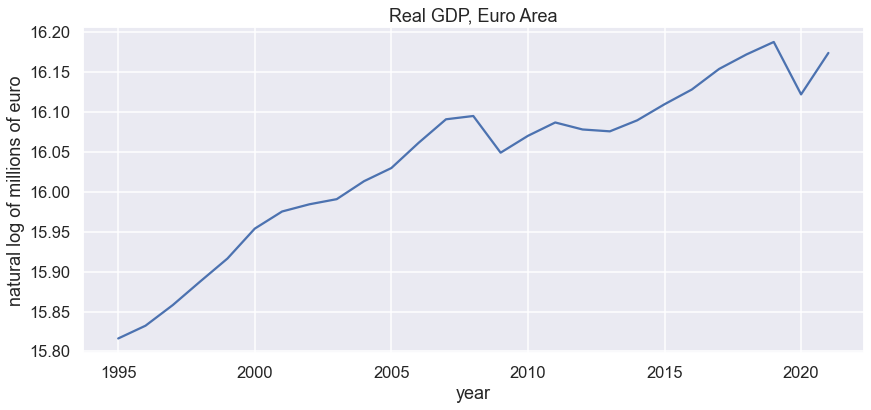

In [3]:
fig = data.plot(figsize=(14,6), title=title,ylabel=ylabel)

## ARMA(p, q)

$$ z_t = \alpha_1 z_{t-1} + \alpha_2 z_{t-1} + \cdots + \alpha_p z_{t-p} + \varepsilon_{t} + \beta_1 \varepsilon_{t-1} + \cdots + \beta_q \varepsilon_{t-q} $$

in lag operator notation 

$$ 
\begin{align}
\alpha(L) z_t &= \beta(L) \varepsilon_t
\end{align}
$$

ARMA(p, q) is __stationary__ if the AR(p) part is stationary, i.e. if all roots of

$$ \alpha(x) = 1 - \alpha_1 x - \alpha_2 x^2 - \cdots - \alpha_p x^p = 0 $$

are outside the unit circle ($|x|>1$)

* a non-stationary process with one root $x=1$ and the other roots $|x|>1$ is called a __unit root__ process

* if $z_t$ is an unit root process, $\Delta z_t = z_t - z_{t-1} = (1-L) z_t$ is stationary

$$\alpha(x) = \alpha^*(x)(1-x)$$
and 
if all roots of

$$ \alpha^*(x) = 1 - \alpha^*_1 x - \alpha^*_2 x^2 - \cdots - \alpha^*_{p-1} x^{p-1} = 0 $$

are outside the unit circle ($|x|>1$)

the AR part 

$$ 
\begin{align}
\alpha(L) z_t = \alpha^*(L)(1-L)z_t = \alpha^*(L)(z_t - z_{t-1}) = \alpha^*(L)\Delta z_t
\end{align}
$$

* a non-stationary process whose first difference is stationary is called integrated of order one ($I(1)$)

__why "integrated"__:

$$
\Delta z_t = z_t - z_{t-1} = u_t, \;\;\;\;\; u_t \;\; \text{stationary}
$$

$$
\begin{align}
z_t &= z_{t-1} + u_t\\
 &= z_{t-2} + u_{t-1} + u_t\\
&\vdots\\
&=\sum_{j=1}^{t} u_j + z_0
\end{align}
$$

* $z_t$ is the sum (integral) of a process (is an "integrated" process) starting from some initialization $z_0$

* $\sum_{j=1}^{t} u_j$ refered to as a __stochastic trend__
* $\Delta z_t$ is $I(0)$ (stationary, no need to difference)

* a non-stationary process which requres double difference to be stationary is called integrated of order two ($I(2)$)
    * if $z_t$ is $I(2)$ then $\Delta^2 z_t = (1-L)^2 z_t$  is $I(0)$

* etc for $I(d)$.
    * if $z_t$ is $I(d)$ then $\Delta^d$ is $I(0)$
    * $d$ is the order of integration

* if we difference a stationary process, we get another stationary process. However, no differencing was required to achieve stationarity

* stationary process whose cumulative sum is also stationary, are called overdifferenced, and denoted with $I(-1)$

__example:__

$$ z_t = \varepsilon_t - \varepsilon_{t-1}, \;\;\; \varepsilon_t \sim \text{iid} (0, \sigma^2)$$

* $z_t$ is stationary but so is $\varepsilon_t$
* $z_t$ is $I(-1)$
* non-invertible MA part

__another example:__

$$ z_t = \delta_0 + \delta_1 t + \nu_t \;\;\; \text{with stationary } \nu_t$$


$$\Delta z_t = \delta_1 t - \delta_1(t-1) + \Delta \nu_t = \delta_1 + \Delta \nu_t 
$$

is $I(-1)$

* linear time trend (deterministic trend)

* $z_t$ is called __trend-stationary__ process

in the sense that it is non-random

more generally:
    
$$ z_t = \mathbf{x_t}' \delta + \nu_t \;\;\; \text{with stationary } \nu_t, \;\; \operatorname{E} \nu_t = 0$$

where $\mathbf{x_t}$ are known constants

$$ z_t - \mathbf{x_t}' \delta =  \nu_t$$

is stationary

### Gaussian MLE

and, if $\nu_t$ is stationary Gaussian time series process

$$
\boldsymbol \nu \sim \mathcal{N}(\boldsymbol 0, \Sigma)
$$

we have 

$$
\mathbf{z} \sim \mathcal{N}(\boldsymbol \mu, \mathbf{\Sigma})
$$

where 

$$\mathbf{\mu} = \boldsymbol X \delta$$

for example, if $z_t = \delta_0 + \delta_1 t + \nu_t$, the $t$-th row of $\boldsymbol X$ is $[1, t]$

### Models with time trend in Python

Generate $\boldsymbol X$ for

$$z_t = \delta_0 + \delta_1 t + \nu_t, \;\;\; t=1, 2, \cdots, T$$

$$ \mathbf{z}  = \boldsymbol X \delta + \mathbf{\nu}$$

$T \times 2$ matrix with $t$-th row given by $[1, t]$

In [35]:
from statsmodels.tsa.deterministic import DeterministicProcess

T = 500
index = pd.RangeIndex(0, T)
det_proc = DeterministicProcess(index, constant=True, order=1) # constant and a linear (1 order) trend
X = det_proc.in_sample()
X.head()

,const,trend
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0


$$ \mathbf{z}  = \boldsymbol X \delta + \mathbf{\nu}$$

In [36]:
# constant and time trend part
delta = np.array([3, .1])
exog = X.values@delta 

$\nu_t$ as ARMA(1,1) process

In [44]:
alpha = np.array([.8])
beta = np.array([0.1])
ar = np.r_[1, -alpha] # coefficient on z(t) and z(t-1)
ma = np.r_[1, beta]  # coefficients on e(t) and e(t-1)
arma11_process = ArmaProcess(ar, ma)

nu =  arma11_process.generate_sample(T, distrvs=gen.normal)

z = exog + nu

__Option 1__ Estimate indicating constant and time trend

In [45]:
arma_model = ARIMA(z, order=(1, 0, 1), trend="ct")
arma_results = arma_model.fit()
print(arma_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -733.673
Date:                Mon, 28 Mar 2022   AIC                           1477.345
Time:                        10:48:25   BIC                           1498.418
Sample:                             0   HQIC                          1485.614
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0500      0.512      5.954      0.000       2.046       4.054
x1             0.0992      0.002     57.573      0.000       0.096       0.103
ar.L1          0.7971      0.035     22.981      0.0

__Option 2__ Estimate providing exogenous regressors

$$ \mathbf{z}  = \boldsymbol X \delta + \mathbf{\nu}$$

In [46]:
arma_model2 = ARIMA(z, exog=X, order=(1, 0, 1), trend="n")
arma_results2 = arma_model2.fit()
print(arma_results2.summary()) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -733.673
Date:                Mon, 28 Mar 2022   AIC                           1477.345
Time:                        10:48:29   BIC                           1498.418
Sample:                             0   HQIC                          1485.614
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0500      0.512      5.954      0.000       2.046       4.054
trend          0.0992      0.002     57.573      0.000       0.096       0.103
ar.L1          0.7971      0.035     22.981      0.0

## Difference-stationary vs trend-stationary

$$ z_t = \delta_0 + \delta_1 t + \nu_t$$

* __trend-stationary__ if $\nu_t$ is stationary
* __difference-stationary__ if $\nu_t$ is a unit root process

$\nu_t$ is a unit root process if in

$$ 
\begin{align}
\alpha(L) \nu_t &= \beta(L) \varepsilon_t
\end{align}
$$

one of the roots of

$$ \alpha(x) = 1 - \alpha_1 x - \alpha_2 x^2 - \cdots - \alpha_{p+1} x^{p+1} = 0$$

is $x=1$, and the other roots are $|x|>1$

$$\alpha(L) = (1-L)\alpha^{*}(L)$$

all $p$ roots of

$$ \alpha^{*}(x) = 1 - \alpha^{*}_1 x - \alpha^{*}_2 x^2 - \cdots - \alpha^{*}_{p} x^{p} = 0$$

are $|x|>1$

$\Delta \nu_t = (1-L)\nu_t$ is a stationary ARMA(p, q) process

$$ 
\begin{align}
\alpha(L) \nu_t &= \beta(L) \varepsilon_t\\
\alpha^{*}(L) (1-L)\nu_t &= \beta(L) \varepsilon_t\\
\alpha^{*}(L) \Delta \nu_t &= \beta(L) \varepsilon_t
\end{align}
$$

### Difference-stationary process

$$ z_t = \delta_0 + \delta_1 t + \nu_t$$

* $ \nu_t$ is an ARIMA(p, 1, q) process

* $z_t$ is an ARIMAX(p, 1, q) process (ARIMA with __exogenous__ part - constant and time trend)

* $\Delta z_t$ is an ARMAX(p, q) process (ARMA with exogenous part - constant)

$$\Delta z_t = \delta_1 + \Delta v_t $$

model $z$ as regression model with ARIMA errors

### Difference between trend- and difference-stationary models

__example__

$$
\begin{align}
z_t &= \delta_0 + \delta_1 t + \nu_t\\
\nu_t &= \alpha \nu_{t-1} +  \varepsilon_{t} \;\;\;\; |\alpha| \leq 1
\end{align}
$$

at $t+h$

$$
\begin{align}
z_{t+h} &= \delta_0 + \delta_1 (t+h) + \nu_{t+h} \\
\nu_{t+h} &= \alpha \nu_{t+h-1} +  \varepsilon_{t+h}
\end{align}
$$

forecast at $t$:

$$
\begin{align}
\operatorname{E}_t z_{t+h} &= \delta_0 + \delta_1 (t+h) + \operatorname{E}_t \nu_{t+h} \\
\operatorname{E}_t \nu_{t+h} &= \alpha^h \nu_{t}
\\
&\Downarrow\\
\operatorname{E}_t z_{t+h} &= \delta_0 + \delta_1 (t+h) + \alpha^h \nu_{t} \\
\end{align}
$$

* if $|\alpha|<1$, as $h\rightarrow \infty$, $\alpha^h \rightarrow 0$

$$
\operatorname{E}_t z_{t+h} = \delta_0 + \delta_1 (t+h) + \alpha^h \nu_{t} \rightarrow \delta_0 + \delta_1 (t+h) =  \operatorname{E} z_{t+h}
$$

$$
\begin{align}
\operatorname{E}z_{t+h} &= \delta_0 + \delta_1 (t+h) + \operatorname{E}\nu_{t+h} \\
\operatorname{E}\nu_{t+h} &= \alpha \operatorname{E}\nu_{t+h-1} +  \operatorname{E}\varepsilon_{t+h} = 0
\end{align}
$$

For trend-stationary processes:

* the long-run forecast is the unconditional mean of $z_t$ (__mean reversion__)

* the long-run forecast is independent of $z_t$

* shocks to $z_t$ have temporary impact (transitory) 

* if $\alpha=1$, 

$$
\begin{align}
\operatorname{E}_t z_{t+h} &= \delta_0 + \delta_1 (t+h) + \alpha^h \nu_{t} \\
\operatorname{E}_t z_{t+h} &= \delta_0 + \delta_1 (t+h) +  \nu_{t} \\
\operatorname{E}_t z_{t+h} &= \delta_0 + \delta_1 (t+h) +  \underbrace{z_t - \delta_0 - \delta_1 t}_{\nu_t} \\
\operatorname{E}_t z_{t+h} &=  \delta_1 h +  z_t 
\end{align}
$$

For difference-stationary processes:

* the value of $z_t$ has a __permanent__ effect on all future forecasts
    * shocks to $z_t$ have permanent effects

* $z_t$ is expected to grow by $\delta_1$ every period

### Martingale process

if for $\{z_t\}_{-\infty}^{\infty}$

$$ \operatorname{E}(z_{t+1} |z_t,  z_{t-1},  \cdots) = z_t$$

$z_t$ is a martingale process, and $\Delta z_t$ is a martingale difference process

unlike a random walk, martingale process allows for heteroskedasticity or conditional heteroskedasticity

### Beveridge-Nelson decomposition 

* Every difference-stationary process can be written as a sum of a random walk and a stationary component
* the effect of innovations (shocks) can be decomposed into permanent and transitory effects

* ARIMA(p,1,q)

$$ 
\alpha(L)\Delta z_t = \delta_0 + \beta(L)\varepsilon_t
$$

* $\alpha(L)$ is invertible. Why?

* equivalently (by invertability of $\alpha(L)$)

$$
\Delta z_t = \delta_1 + \phi(L)\varepsilon_t \\
$$

$$
\delta_1 = \frac{\delta_0}{\alpha(1)}, \;\;\;\phi(L) = \frac{\beta(L)}{\alpha(L)} \;\;\;\alpha(1) = 1 - \alpha_1 - \cdots - \alpha_p 
$$

__(a bit of magic here...)__

Since 1 is a root of the polinomial

$$\phi(L) - \phi(1) $$

it can be witten as

$$\phi(L) - \phi(1) = \phi^{*}(L) (1-L)$$

and 

$$\phi(L)  = \phi^{*}(L) (1-L) + \phi(1)$$

where 

$$ \phi^*(L) =\frac{\phi(L) - \phi(1)}{(1-L)} \Rightarrow \phi_j^* =-\sum_{i=j+1} \phi_i$$

$$
\begin{align}
\Delta z_t &= \delta_1 + \phi(L)\varepsilon_t\\
(1-L) z_t &= \delta_1 + \phi(1)\varepsilon_t  + \phi^{*}(L) (1-L)\varepsilon_t\\
z_t &= (1-L)^{-1}\delta_1  + (1-L)^{-1}\phi(1)\varepsilon_t + \phi^{*}(L)\varepsilon_t\\
\end{align}
$$

denote $z_t^p = (1-L)^{-1}\delta_1  + (1-L)^{-1}\phi(1)\varepsilon_t$

then, 

$$
\begin{align}
(1-L) z_t^p &=\delta_1  + \phi(1)\varepsilon_t\\
z_t^p - z_{t-1}^p&=\delta_1  + \phi(1)\varepsilon_t\\
z_t^p &= \delta_1 + z_{t-1}^p + \phi(1)\varepsilon_t\\
\end{align}
$$

Therefore

$$
\begin{align}
z_t &= z_t^p + z_t^s\\
\\
&\text{where}\\
\\
z_t^p &= \delta_1 + z_{t-1}^p + \phi(1) \varepsilon_t\\
z_t^s &= \phi^*(L) \varepsilon_t
\end{align}
$$

* $z^p_t$ - permanent component (trend)
* $z^s_t$ - transitory component (cycle)

*  $\varepsilon_t$ has a permanent impact on $z_t$ through $z_t^p$
*  $\varepsilon_t$ has a transitory impact on $z_t$ through $z_t^s$
* relative importance of permanent/transitory impact depends on the value of $\phi(1)$

__example ARIMA(0,1,1)__

$$
\Delta z_t =  \varepsilon_{t}+ \beta \varepsilon_{t-1}
$$

$$
\begin{align}
z_t &= z_{t-1} + \varepsilon_{t}+ \beta \varepsilon_{t-1}\\
    &= z_{t-2} + (\varepsilon_{t-1}+ \beta \varepsilon_{t-2}) + \varepsilon_{t}+ \beta \varepsilon_{t-1}\\
&\;\;\;\vdots \;\;\;\;\;\; (\text{assuming } z_0 = \varepsilon_0 = 0)\\  
    &= \sum^{t}_{j=1} \varepsilon_{j} + \beta \sum^{t-1}_{j=1} \varepsilon_{j} \;\;\; (\text{add and subtract } \beta\varepsilon_{t}) \\
    &= \underbrace{(1 + \beta)\sum^{t}_{j=1} \varepsilon_{j}}_{z_t^p} + \underbrace{(- \beta  \varepsilon_{t})}_{z_t^s}\\
\end{align}
$$

$$
\begin{align}
z_t^p &= (1 + \beta)\sum^{t}_{j=1} \varepsilon_{j}\\
&= (1 + \beta)\sum^{t-1}_{j=1} \varepsilon_{j} + (1 + \beta)\varepsilon_{t} \\
&=  z_{t-1}^p + (1 + \beta)\varepsilon_{t} \\
\end{align}
$$

### Random walk with a drift model:
    
$$ z_t = \delta + z_{t-1} + \varepsilon_t$$


$$
\begin{align}
z_t = \delta t + \varepsilon_t &+ \varepsilon_{t-1} + \varepsilon_{t-2} + \cdots + \varepsilon_{1} + z_0\\
\\
\operatorname{E} z_t &= \delta t + \operatorname{E} z_0\\
\operatorname{var} (z_t) &= \sigma^2 t + \operatorname{var}(z_0)
\end{align}
$$

#### Beveridge-Nelson decomposition 

Every difference-stationary processes can be written as a sum of a random walk and a stationary component


* many macro variables are well represented by ARIMA(p,1,q) models
* every ARIMA(p,1,q) model has a random walk stochastic trend

$$ \Downarrow $$

* the growth in macro variables can be characterized by stochastic trends

### Forecasting integrated variables

* if $z_t$ is $I(1)$, we estimate and forecast using $\Delta z_t$

* from the forecasts of $\Delta z_{t+i}$, $i=1, 2, \cdots, h$

$$ z^f_{t+h} = z_t + \sum_{i=1}^{h} \Delta z^f_{t+i}$$

### Detecting stochastic trends by unit root test

Unit root tests are one-sided tests:

* $H_0$: unit root
* $H_1$: stationary

### Augmented Dickey–Fuller test

Consider AR(2) process:

$$z_t = \alpha_1 z_{t-1} + \alpha_2 z_{t-2}  + \varepsilon_t$$

re-write as 

$$
\begin{align}
z_t &= \alpha_1 z_{t-1} + (\alpha_2 z_{t-1} - \alpha_2 z_{t-1}) + \alpha_2 z_{t-2}  + \varepsilon_t\\
 &= (\alpha_1 + \alpha_2) z_{t-1} - \alpha_2 (z_{t-1} - z_{t-2} ) + \varepsilon_t\\
 &= (\alpha_1 + \alpha_2) z_{t-1} - \alpha_2 \Delta z_{t-1}  + \varepsilon_t\\
\end{align}
$$

and 

$$
\begin{align}
 z_t - z_{t-1} &= (\alpha_1 + \alpha_2 -1) z_{t-1} - \alpha_2 \Delta z_{t-1}  + \varepsilon_t\\
 \Delta z_t  &= (\alpha_1 + \alpha_2 - 1) z_{t-1} - \alpha_2 \Delta z_{t-1}  + \varepsilon_t\\
\end{align}
$$

For AR(2) process, unit root means that $x=1$ is a solution to

$$\alpha(x) = 1-\alpha_1 x - \alpha_2x^2=0$$

i.e

$$\alpha(1) = 1-\alpha_1  - \alpha_2=0$$

Therefore, testing for unit root is equivalent to testing that $\rho=0$ in 

$$
\begin{align}
 \Delta z_t  &= (\alpha_1 + \alpha_2 - 1) z_{t-1} - \alpha_2 \Delta z_{t-1}  + \varepsilon_t\\\\
  &= \rho z_{t-1} + \alpha^*_1 \Delta z_{t-1}  + \varepsilon_t\\
\end{align}
$$

In general AR(p) model for $z_t$

$$
\begin{align}
 \Delta z_t  &= (\alpha_1 + \alpha_2 + \cdots + \alpha_p - 1) z_{t-1} + \alpha_1^* \Delta z_{t-1} + \cdots - \alpha_{p-1}^* \Delta z_{t-p+1} + \varepsilon_t \\
 \Delta z_t  &= \rho z_{t-1} + \sum_{i=1}^{p-1} \alpha_i^* \Delta z_{t-i} + \varepsilon_t\\
\end{align}
$$

* testing for unit root is equivalent to testing that $\rho=0$

$$
 \Delta z_t = \rho z_{t-1} + \sum_{i=1}^{p-1} \alpha_i^* \Delta z_{t-i} + \varepsilon_t 
$$(equation-1)

* in {eq}`equation-1` the $H_1$ is that $z_t$ is a stationary __mean 0__ AR(p) process

* to test for unit root agains $H_1$ that $z_t$ is a stationary around a constant ($\neq 0$) mean, estimate

$$
 \Delta z_t  = \delta_0 + \rho z_{t-1} + \sum_{i}^{p-1} \alpha_i^* \Delta z_{t-i} + \varepsilon_t
$$(equation-2)

* to test for unit root agains $H_1$ that $z_t$ is a stationary around a deterministic linear time trend (__trend-stationary__)

$$
 \Delta z_t  = \delta_0 + \delta_1 t + \rho z_{t-1} + \sum_{i}^{p-1} \alpha_i^* \Delta z_{t-i} + \varepsilon_t
$$(equation-2)

+ appropriate for series that exhibit growth over the long run 


The test for unit root is a test of $\rho=0$ (unit root) against the alternative of $\rho<0$ (stationary)

* The asymptotic distribution of the test statistic for $\rho$ is non-standard. 
* The critical values of the test statistics are obtained by Monte Carlo simulations, and depend of whether constant and time trend are included
* The null hypothesis of a unit root is rejected when value of the test statistics is below the critical value. 
* If the null hypothesis cannot be rejected, $z_t$ should be differenced prior to estimation

## ADF test in Python

In [12]:
df = pd.read_stata(r"C:\Users\eeu227\Documents\PROJECTS\econ108-repos\econ108-practice\EconometricsData\FRED-QD\FRED-QD.dta")
rgdp = df[['time', 'gdpc1']].set_index('time')['1961q1':].rename(columns={'gdpc1': 'rGDP'})
rgdp = np.log(rgdp)

In [13]:
df = pd.read_stata(r"C:\Users\eeu227\Documents\PROJECTS\econ108-repos\econ108-practice\EconometricsData\FRED-MD\FRED-MD.dta")
unemp = df[['time', 'unrate']].set_index('time')['1961-01':]

In [15]:
df = pd.read_stata(r"C:\Users\eeu227\Documents\PROJECTS\econ108-repos\econ108-practice\EconometricsData\FRED-MD\FRED-MD.dta")
cpi = np.log(df[['time', 'cpiaucsl']].set_index('time')['1961-01':])

dcpi = (cpi.diff(12)*100).dropna()

### Real GDP

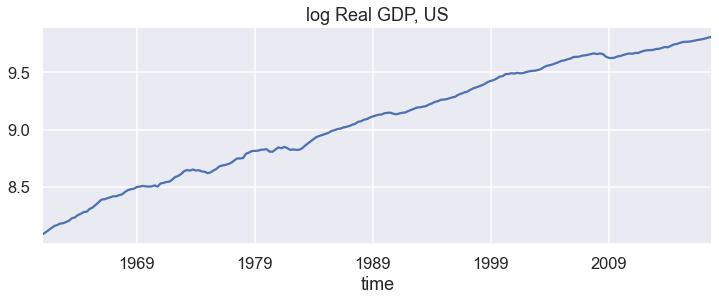

In [16]:
fig = rgdp.plot(figsize=(12,4), title='log Real GDP, US', legend=False)

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def get_adfresults(dftest):
    dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    return dfoutput

ADF with constant and trend, 4 lags

In [19]:
dftest = adfuller(rgdp, maxlag=4, autolag=None, regression='ct')
dftest

(-2.0141544954585036,
 0.5937024444875985,
 4,
 223,
 {'1%': -3.9999506167815206,
  '5%': -3.4303636888103926,
  '10%': -3.138725564735756})

In [20]:
get_adfresults(dftest)

Test Statistic                  -2.014154
p-value                          0.593702
#Lags Used                       4.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.999951
Critical Value (5%)             -3.430364
Critical Value (10%)            -3.138726
dtype: float64

Automatically determine optimal number of lags using AIC

In [21]:
dftest = adfuller(rgdp, autolag="AIC", regression='ct')
get_adfresults(dftest)

Test Statistic                  -2.157741
p-value                          0.513651
#Lags Used                       2.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.999579
Critical Value (5%)             -3.430185
Critical Value (10%)            -3.138621
dtype: float64

### Unemployment Rate

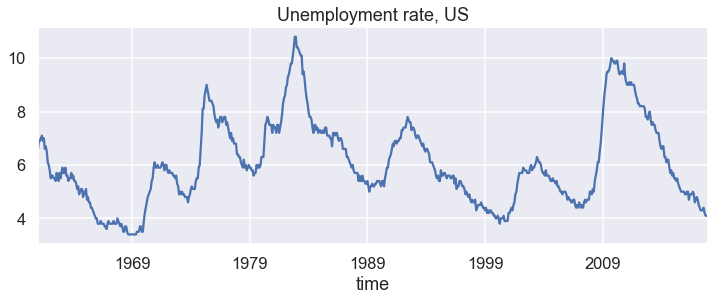

In [22]:
fig = unemp.plot(figsize=(12,4), title='Unemployment rate, US', legend=False)

In [23]:
dftest = adfuller(unemp, autolag='AIC', regression='c')
get_adfresults(dftest)

Test Statistic                  -2.996063
p-value                          0.035264
#Lags Used                      12.000000
Number of Observations Used    671.000000
Critical Value (1%)             -3.440133
Critical Value (5%)             -2.865857
Critical Value (10%)            -2.569069
dtype: float64

### Consumer Price Inflation

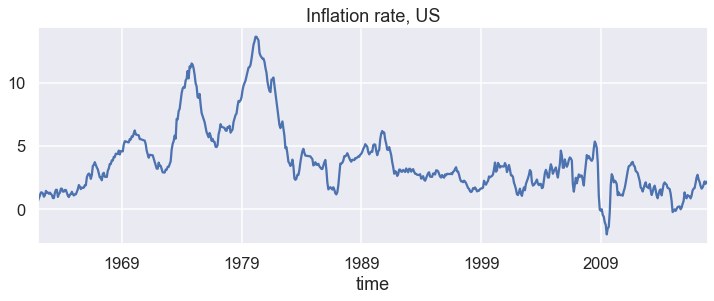

In [24]:
fig = dcpi.plot(figsize=(12,4), title='Inflation rate, US', legend=False)

In [25]:
dftest = adfuller(dcpi, autolag='AIC', regression='c')
get_adfresults(dftest)

Test Statistic                  -2.804916
p-value                          0.057575
#Lags Used                      15.000000
Number of Observations Used    656.000000
Critical Value (1%)             -3.440358
Critical Value (5%)             -2.865956
Critical Value (10%)            -2.569122
dtype: float64

## ADF test using ARCH

In [27]:
from arch.unitroot import ADF

In [28]:
adf = ADF(rgdp, trend="ct")
adf.summary()

Test Statistic,-2.158
P-value,0.514
Lags,2


#### Examine the regression results

In [29]:
reg_res = adf.regression
print(reg_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     11.76
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           1.13e-08
Time:                        10:30:38   Log-Likelihood:                 786.27
No. Observations:                 225   AIC:                            -1563.
Df Residuals:                     220   BIC:                            -1545.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0217      0.010     -2.158      0.0

#### Examine the regression residuals

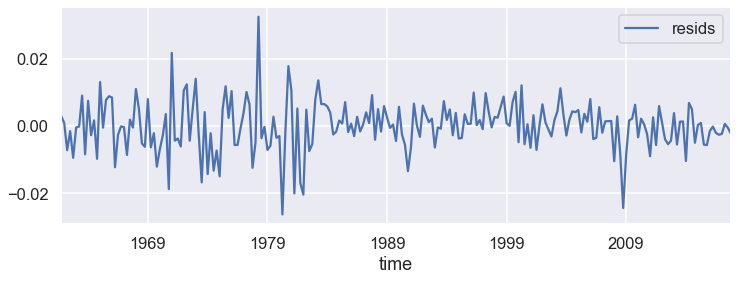

In [30]:
resids = pd.DataFrame(reg_res.resid)
resids.index = rgdp.index[3:]
resids.columns = ["resids"]
fig = resids.plot(figsize=(12,4))

(-0.3, 1.1)

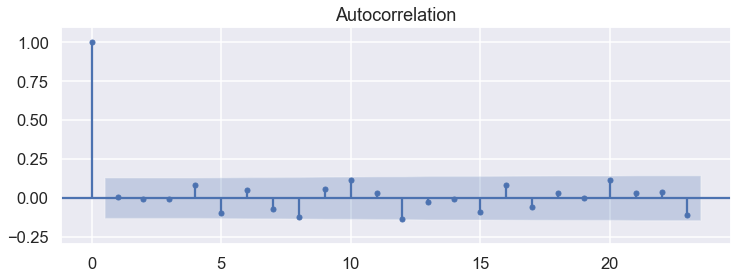

In [31]:

fig, ax = plt.subplots(figsize=(12,4))
fig = sm.graphics.tsa.plot_acf(reg_res.resid, lags=23, ax=ax)
ax.set_ylim([-0.3, 1.1])